## Digit recogniser ##

We first start by importing key modules:

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
import torch
from torch.utils.data import TensorDataset, DataLoader
import random
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
import torch.nn.functional as F

Now, we load in the data and split it:

In [3]:
X = np.load("emnist_hex_images.npy")
y = np.load("emnist_hex_labels.npy")

# Splitting data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Now, a quick statistical overview:

In [4]:
# Combine features and label for a unified overview
combined_df = pd.DataFrame(np.column_stack((X_train, y_train)))
combined_df.describe()

,0,1,2,3,4,5,6,7,8,9,...,391,392,393,394,395,396,397,398,399,400
count,75461.000000,75461.000000,75461.000000,75461.000000,75461.000000,75461.000000,75461.000000,75461.000000,75461.000000,75461.000000,...,75461.000000,75461.000000,75461.000000,75461.000000,75461.000000,75461.000000,75461.000000,75461.000000,75461.000000,75461.000000
mean,26.442520,26.340746,26.399584,26.302885,26.183287,26.025523,25.748360,25.614304,25.320006,24.715866,...,25.159924,25.407336,25.812141,25.943971,26.252435,26.336664,26.540067,26.428274,26.345092,7.138032
std,21.142201,21.008777,21.055106,21.057020,21.081442,21.058760,20.989201,21.039087,21.084657,20.964091,...,21.088999,21.076666,21.053880,21.040270,21.121541,21.066223,21.061336,21.079682,21.022896,4.745188
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8.000000,8.000000,8.000000,8.000000,7.000000,7.000000,7.000000,7.000000,6.000000,5.000000,...,6.000000,6.000000,7.000000,7.000000,7.000000,8.000000,8.000000,8.000000,8.000000,3.000000
50%,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,23.000000,23.000000,22.000000,...,23.000000,23.000000,24.000000,24.000000,24.000000,24.000000,25.000000,24.000000,24.000000,7.000000
75%,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,40.000000,40.000000,40.000000,39.000000,...,40.000000,40.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,11.000000
max,122.000000,125.000000,120.000000,124.000000,129.000000,118.000000,122.000000,120.000000,126.000000,114.000000,...,129.000000,126.000000,131.000000,119.000000,119.000000,121.000000,123.000000,122.000000,125.000000,16.000000


The features are not that helpful, but the mean of the label (final column) is around 7.15, which is about halfway between 0 and 16. This indicates an even distribution, but let's look at a histogram for a more detailed view:

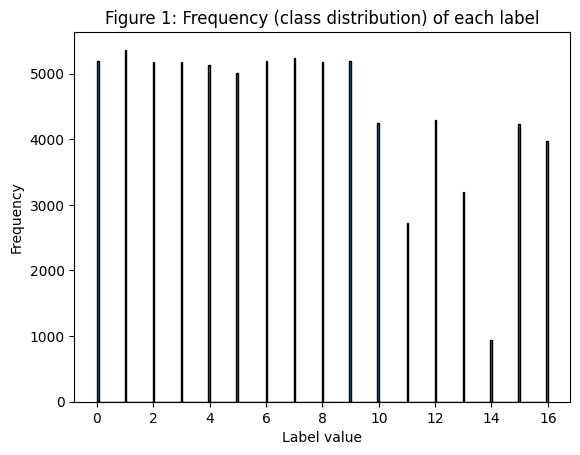

In [131]:
plt.hist(y_train, bins='sqrt', edgecolor='black')
plt.title('Figure 1: Frequency (class distribution) of each label')
plt.xlabel('Label value')
plt.ylabel('Frequency')
plt.show()

We can see that it isn't completely uniform after all. For example, we can see that labels 10, 13, and 14 are quite low in relation to the other labels. Due to this, accuracy may not be the best measure. We can consider using F1 score, which accounts for such scenarios. Namely, weighted F1, which accounts for this by using supports.

Let's check if there is missing data:

In [132]:
has_null = combined_df.isna().any().any()
print(has_null)

False


The statistical overview was truncated somewhat, so let's verify the highest value in the features:

In [133]:
print(np.amax(X_train))

255


Let's pick an image and display it, just to get an overview:

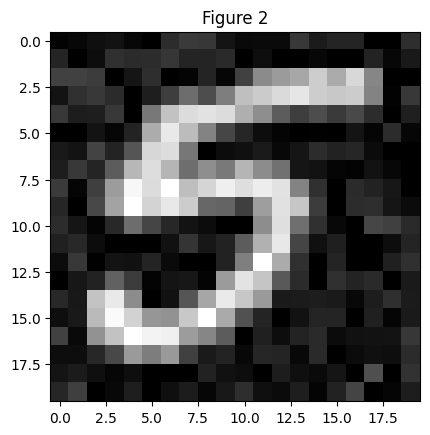

In [134]:
# Reshape array of length 400 to 20x20 matrix
img_example = X_train[4000].reshape(20, 20)
plt.imshow(img_example, vmin=0, vmax=255, cmap="gray")
plt.title("Figure 2")
plt.show()

This is clearly the number 5. Let's see another digit that might be less clear:

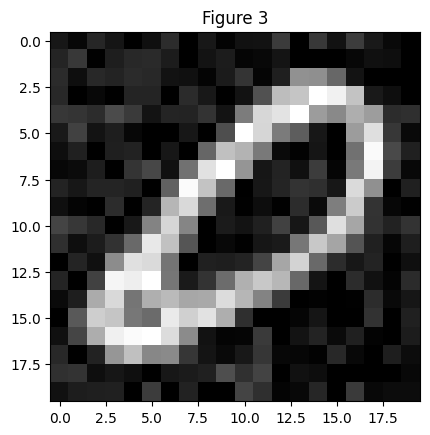

In [135]:
img_example_unclear = X_train[7000].reshape(20, 20)
plt.imshow(img_example_unclear, vmin=0, vmax=255, cmap="gray")
plt.title("Figure 3")
plt.show()

This could be either 0 or D, but the writing is quite confusing, so images like these could be of interest when we look at misclassifications later on.

It's important to bear in mind that the images show hexadecimal values 0 to F, which in decimal (which our labels show), are 0 to 16 (16 is an empty image). Now, we are going to make three classifiers for these digits, experimenting with possible hyperparameters to pick out the best:

The first classifier is the k-nearest neighbours classifier:

In [136]:
# Define a k-fold iterator for cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [137]:
# Define pipeline
pipe_knn = Pipeline([
    ('scaler', MinMaxScaler()),
    ('knn', KNeighborsClassifier())
])

# Define hyperparameters
k_vals = range(1, 20, 2)
weights = ['uniform', 'distance']
kNN_params = {'knn__n_neighbors': k_vals, 'knn__weights': weights}

# Use grid search
grid_knn = GridSearchCV(pipe_knn, kNN_params, cv=kf, scoring='f1_weighted', n_jobs=-1)
grid_knn.fit(X_train, y_train)

# Extract results
knn_res = pd.DataFrame(grid_knn.cv_results_)
knn_sorted_idx = np.argsort(knn_res['mean_test_score'])[::-1]

# Rank results in descending order
print("Rankings based on F1 score:")
for i in knn_sorted_idx:
    print(f"Parameters: {knn_res['params'][i]} with an F1 score of {round(knn_res['mean_test_score'][i], 5)}")

# Print out the best model
print('\n')
print(f'F1 score of best kNN model: {round(grid_knn.best_score_, 5)} with k = {grid_knn.best_params_["knn__n_neighbors"]} and the {grid_knn.best_params_["knn__weights"]} weight')

Rankings based on F1 score:
Parameters: {'knn__n_neighbors': 3, 'knn__weights': 'distance'} with an F1 score of 0.93954
Parameters: {'knn__n_neighbors': 5, 'knn__weights': 'distance'} with an F1 score of 0.93811
Parameters: {'knn__n_neighbors': 1, 'knn__weights': 'uniform'} with an F1 score of 0.93703
Parameters: {'knn__n_neighbors': 1, 'knn__weights': 'distance'} with an F1 score of 0.93703
Parameters: {'knn__n_neighbors': 3, 'knn__weights': 'uniform'} with an F1 score of 0.93568
Parameters: {'knn__n_neighbors': 7, 'knn__weights': 'distance'} with an F1 score of 0.93514
Parameters: {'knn__n_neighbors': 5, 'knn__weights': 'uniform'} with an F1 score of 0.9351
Parameters: {'knn__n_neighbors': 9, 'knn__weights': 'distance'} with an F1 score of 0.93271
Parameters: {'knn__n_neighbors': 7, 'knn__weights': 'uniform'} with an F1 score of 0.93237
Parameters: {'knn__n_neighbors': 9, 'knn__weights': 'uniform'} with an F1 score of 0.93006
Parameters: {'knn__n_neighbors': 11, 'knn__weights': 'dist

The ranking can be tricky to reason about, so it can help to visualise the scores for different k and weights:

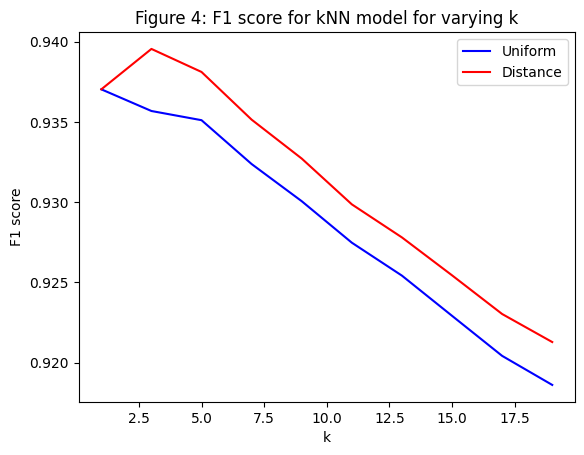

In [156]:
# Extract data based on weights
uniform_scores = knn_res[knn_res['param_knn__weights'] == 'uniform']['mean_test_score']
distance_scores = knn_res[knn_res['param_knn__weights'] == 'distance']['mean_test_score']

# Plot results
plt.plot(k_vals, uniform_scores, label='Uniform', color='blue')
plt.plot(k_vals, distance_scores, label='Distance', color='red')
plt.xlabel("k")
plt.ylabel("F1 score")
plt.title("Figure 4: F1 score for kNN model for varying k")
plt.legend()
plt.show()

Now, we build the multilayer perceptron (MLP) model:

In [11]:
# Suppress convergence warning in order to keep output clean
warnings.filterwarnings('ignore', category=ConvergenceWarning)

pipe_mlp = Pipeline([
    ('scaler', MinMaxScaler()),
    ('mlp', MLPClassifier(random_state=42))
])

# Define hidden layers and L2 regularisation hyperparameters
hidden_layers = [(50, 25), (100, 50), (50, 100, 50), (100, 50, 25), (250, 150)]
alphas = [0.001, 0.01, 0.1, 1]
solver = ['lbfgs', 'adam']

mlp_params = {'mlp__hidden_layer_sizes': hidden_layers, 'mlp__alpha': alphas, 'mlp__solver': solver}
grid_mlp = GridSearchCV(pipe_mlp, mlp_params, cv=kf, scoring='f1_weighted', n_jobs=-1)
grid_mlp.fit(X_train, y_train)

mlp_res = pd.DataFrame(grid_mlp.cv_results_)
mlp_sorted_idx = np.argsort(mlp_res['mean_test_score'])[::-1]

print("Rankings based on F1 score:")
for i in mlp_sorted_idx:
    print(f"Parameters: {mlp_res['params'][i]} with an F1 score of {round(mlp_res['mean_test_score'][i], 5)}")

print('\n')
print(f'F1 score of best MLP model: {round(grid_mlp.best_score_, 5)} with hidden layers = {grid_mlp.best_params_["mlp__hidden_layer_sizes"]}, alpha = {grid_mlp.best_params_["mlp__alpha"]}, and the {grid_mlp.best_params_["mlp__solver"]} solver')

Rankings based on F1 score:
Parameters: {'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (250, 150), 'mlp__solver': 'adam'} with an F1 score of 0.96314
Parameters: {'mlp__alpha': 0.1, 'mlp__hidden_layer_sizes': (250, 150), 'mlp__solver': 'adam'} with an F1 score of 0.96052
Parameters: {'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (250, 150), 'mlp__solver': 'adam'} with an F1 score of 0.95944
Parameters: {'mlp__alpha': 0.1, 'mlp__hidden_layer_sizes': (100, 50), 'mlp__solver': 'adam'} with an F1 score of 0.95812
Parameters: {'mlp__alpha': 0.1, 'mlp__hidden_layer_sizes': (100, 50, 25), 'mlp__solver': 'adam'} with an F1 score of 0.9542
Parameters: {'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (100, 50), 'mlp__solver': 'adam'} with an F1 score of 0.95317
Parameters: {'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (250, 150), 'mlp__solver': 'lbfgs'} with an F1 score of 0.95268
Parameters: {'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (250, 150), 'mlp__solver': 'lbfgs'} with an F1 scor

Finally, we test the random forest classifier:

In [12]:
# Create RF pipeline, train model, and extract results, as in the previous models
pipe_rf = Pipeline([
    ('scaler', MinMaxScaler()),
    ('rf', RandomForestClassifier(random_state=42))
])

# Define hyperparameters for tree count and impurity measure
estimators = [50, 100, 250, 500]
impurity = ['gini', 'entropy']

rf_params = {'rf__n_estimators': estimators, 'rf__criterion': impurity}
grid_rf = GridSearchCV(pipe_rf, rf_params, cv=kf, scoring='f1_weighted', n_jobs=-1)
grid_rf.fit(X_train, y_train)

rf_res = pd.DataFrame(grid_rf.cv_results_)
rf_sorted_idx = np.argsort(rf_res['mean_test_score'])[::-1]

print("Rankings based on F1 score:")
for i in rf_sorted_idx:
    print(f"Parameters: {rf_res['params'][i]} with an F1 score of {round(rf_res['mean_test_score'][i], 5)}")

print('\n')
print(f'F1 score of best RF model: {round(grid_rf.best_score_, 5)} with {grid_rf.best_params_["rf__n_estimators"]} trees and impurity of {grid_rf.best_params_["rf__criterion"]}')

Rankings based on F1 score:
Parameters: {'rf__criterion': 'entropy', 'rf__n_estimators': 500} with an F1 score of 0.93181
Parameters: {'rf__criterion': 'gini', 'rf__n_estimators': 500} with an F1 score of 0.93127
Parameters: {'rf__criterion': 'gini', 'rf__n_estimators': 250} with an F1 score of 0.93063
Parameters: {'rf__criterion': 'entropy', 'rf__n_estimators': 250} with an F1 score of 0.93047
Parameters: {'rf__criterion': 'gini', 'rf__n_estimators': 100} with an F1 score of 0.92711
Parameters: {'rf__criterion': 'entropy', 'rf__n_estimators': 100} with an F1 score of 0.92705
Parameters: {'rf__criterion': 'entropy', 'rf__n_estimators': 50} with an F1 score of 0.92199
Parameters: {'rf__criterion': 'gini', 'rf__n_estimators': 50} with an F1 score of 0.92163


F1 score of best RF model: 0.93181 with 500 trees and impurity of entropy


Looking closely at this result with a visualisation:

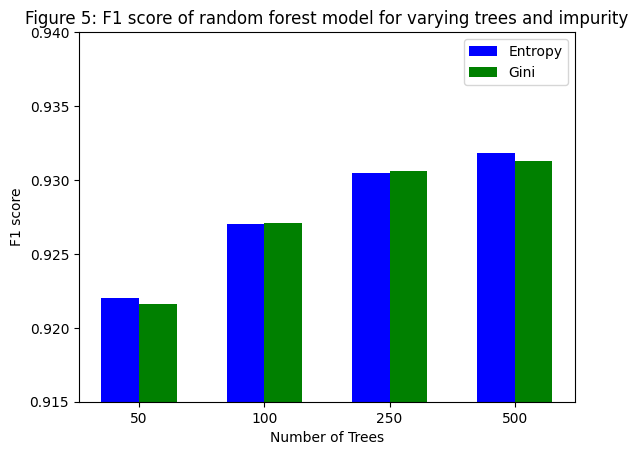

In [13]:
# Get grouped scores for entropy and gini
entropy_scores = rf_res[rf_res['param_rf__criterion'] == 'entropy']['mean_test_score']
gini_scores = rf_res[rf_res['param_rf__criterion'] == 'gini']['mean_test_score']

# Plot grouped bar chart
index = np.arange(len(estimators))
bar_width = 0.3
plt.bar(index, entropy_scores, bar_width, label='Entropy', color='blue')
plt.bar(index + bar_width, gini_scores, bar_width, label='Gini', color='green')
plt.xlabel("Number of Trees")
plt.ylabel("F1 score")
plt.title("Figure 5: F1 score of random forest model for varying trees and impurity")
plt.xticks(index + bar_width / 2, estimators)
plt.ylim(0.915, 0.94)
plt.legend()
plt.show()

Picking out the best model:

In [149]:
# Filter the best models for each category and then the best among those
best_models_info = [(grid_knn, 'kNN'), (grid_mlp, 'MLP'), (grid_rf, 'Random Forest')]
best_model_info = max(best_models_info, key=lambda x: x[0].best_score_)

print(f'Best of all three models: {best_model_info[1]} having {best_model_info[0].best_params_} with F1 score of {round(best_model_info[0].best_score_, 5)} on validation data')

Best of all three models: MLP having {'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (250, 150), 'mlp__solver': 'adam'} with F1 score of 0.96314 on validation data


It can help to visualise the training losses as the best model trains (unfortunately, the model does not support validation loss):

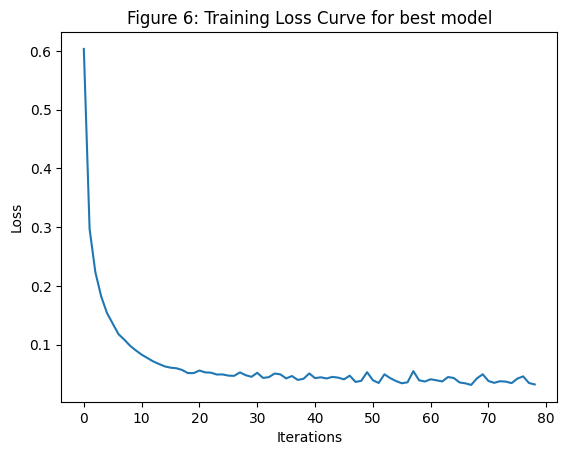

In [150]:
# Extract model from pipeline and plot loss curve
overall_best_model = best_model_info[0].best_estimator_

loss_curve = None

# Check if model contains loss curve, and plot if it does
for name, step in overall_best_model.named_steps.items():
    if hasattr(step, 'loss_curve_'):
        loss_curve = step.loss_curve_
        break

if loss_curve is None:
    print("The best model does not have a training loss curve")
else:
    plt.plot(loss_curve)
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.title("Figure 6: Training Loss Curve for best model")
    plt.show()

Let's test the best overall model on test data:

In [151]:
# Predict on test data and extract score
test_pred = overall_best_model.predict(X_test)
test_f1 = f1_score(y_test, test_pred, average='weighted')
print(f'F1 score of best model ({best_model_info[1]} with {best_model_info[0].best_params_}) on test data: {round(test_f1, 5)}')

F1 score of best model (MLP with {'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (250, 150), 'mlp__solver': 'adam'}) on test data: 0.96602


We can take a more in-depth look at this result by creating a confusion matrix:

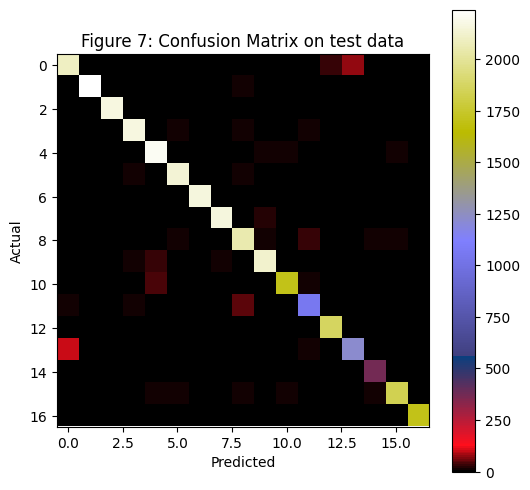

In [152]:
# Comparing predicted vs actual labels
conmat_test = confusion_matrix(y_test, test_pred)

# Create plot using subplots
fig, ax = plt.subplots(figsize=(6, 6))
# gist_stern is a good colourmap to enhance values not far above 0
cax = ax.imshow(conmat_test, cmap='gist_stern')
cbar = plt.colorbar(cax)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Figure 7: Confusion Matrix on test data')

plt.show()

We can also calculate the error rate:

In [153]:
# Calculate error rate by dividing number of incorrect predictions by total predictions
total_pred = np.sum(conmat_test)
correct_pred = np.trace(conmat_test)
incorrect_pred = total_pred - correct_pred
error_rate = incorrect_pred / total_pred

print(f'Error rate: {round(error_rate, 5)}')

Error rate: 0.03395


Now, let's take a look at some misclassifications from the test data:

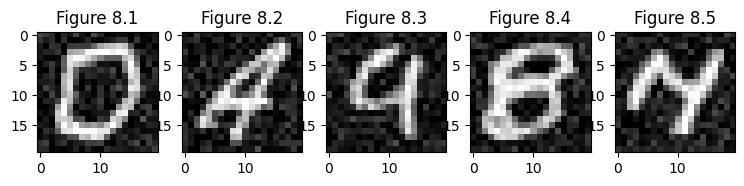

In [154]:
# Get list of misclassified indices in test data
miscl_idxs_test = list(np.where(y_test != test_pred)[0])

# Undo scaling by multiplying by 255
miscl_img1 = X_test[miscl_idxs_test[10]].reshape(20, 20)
miscl_img2 = X_test[miscl_idxs_test[7]].reshape(20, 20)
miscl_img3 = X_test[miscl_idxs_test[4]].reshape(20, 20)
miscl_img4 = X_test[miscl_idxs_test[12]].reshape(20, 20)
miscl_img5 = X_test[miscl_idxs_test[53]].reshape(20, 20)

# Subplots for each image
fig, (p1, p2, p3, p4, p5) = plt.subplots(1, 5, figsize=(9, 9))
p1.imshow(miscl_img1, vmin=0, vmax=255, cmap="gray")
p2.imshow(miscl_img2, vmin=0, vmax=255, cmap="gray")
p3.imshow(miscl_img3, vmin=0, vmax=255, cmap="gray")
p4.imshow(miscl_img4, vmin=0, vmax=255, cmap="gray")
p5.imshow(miscl_img5, vmin=0, vmax=255, cmap="gray")

# Assign titles
p1.title.set_text('Figure 8.1')
p2.title.set_text('Figure 8.2')
p3.title.set_text('Figure 8.3')
p4.title.set_text('Figure 8.4')
p5.title.set_text('Figure 8.5')

plt.show()

### Trying to model using a convolutional neural network:

In [6]:
# Make a seeding function for reproducibility
def seeder(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seeder()

In [28]:
class MNISTDataset(TensorDataset):
    def __init__(self, features, labels, transform=None):
        self.features = features
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        feature = self.features[idx].reshape(1, 20, 20)
        label = self.labels[idx]
        if self.transform:
            feature = self.transform(feature)
        return feature, label

In [39]:
mean = X_train.mean()
std = X_train.std()

transform = transforms.Compose([
    transforms.Normalize((mean,), (std,))
])

# Convert NumPy arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create a TensorDataset
seeder()
train_dataset = MNISTDataset(X_train_tensor, y_train_tensor, transform)
test_dataset = MNISTDataset(X_test_tensor, y_test_tensor, transform)

seeder()
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [37]:
class CNN_MNIST(nn.Module):
    def __init__(self):
        super(CNN_MNIST, self).__init__() # 20x20
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, stride=1, padding=1) # 18x18
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1) # 18x18
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0) # 9x9
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=0) # 7x7
        self.fc1 = nn.Linear(128 * 7 * 7, 64)
        self.fc2 = nn.Linear(64, 17)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = x.view(-1, 128 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [38]:
def train(n_epochs, optimizer, model, loss_fn, train_loader):

    training_losses = [] 

    for epoch in range(n_epochs):
        model.train()
        total_loss = 0

        # Compute training loss and update
        for i, (features, labels) in enumerate(train_loader):
            # Forward pass
            outputs = model(features)
            loss = loss_fn(outputs, labels)

            # Zero gradients
            optimizer.zero_grad()
            # Backward pass and gradient descent
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        training_losses.append(avg_loss)

        print(f'Epoch {epoch+1}/{n_epochs}, Training Loss: {avg_loss:.4f}')

    print('Training complete!')

    return training_losses

In [40]:
seeder()
cnn_model = CNN_MNIST()

opt = torch.optim.Adam(cnn_model.parameters(), lr=0.001)

n_epochs = 15

loss_fn = nn.CrossEntropyLoss()

training_loss = train(n_epochs, opt, cnn_model, loss_fn, train_loader)

Epoch 1/15, Training Loss: 0.1858
Epoch 2/15, Training Loss: 0.0665
Epoch 3/15, Training Loss: 0.0484
Epoch 4/15, Training Loss: 0.0368
Epoch 5/15, Training Loss: 0.0278
Epoch 6/15, Training Loss: 0.0235
Epoch 7/15, Training Loss: 0.0198
Epoch 8/15, Training Loss: 0.0169
Epoch 9/15, Training Loss: 0.0153
Epoch 10/15, Training Loss: 0.0140
Epoch 11/15, Training Loss: 0.0109
Epoch 12/15, Training Loss: 0.0119
Epoch 13/15, Training Loss: 0.0103
Epoch 14/15, Training Loss: 0.0084
Epoch 15/15, Training Loss: 0.0103
Training complete!


In [41]:
cnn_model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for i, (features, labels) in enumerate(test_loader):
        outputs = cnn_model(features)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_targets.extend(labels.cpu().numpy())

weighted_f1_cnn = f1_score(all_targets, all_preds, average='weighted')
print(f'Weighted F1 Score of the model on the test images: {weighted_f1_cnn:.4f}')

Weighted F1 Score of the model on the test images: 0.9805
